# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [ ]:
# The new version of dataset is only available in the tfds-nightly package.
#%pip --no-cache-dir install tensorflow-datasets --user
# DON'T MISS TO RESTART THE KERNEL

In [ ]:
#The new version of dataset is only available in the tfds-nightly package. 
%pip --no-cache-dir install tfds-nightly --user 
!pip install tensorflow --upgrade --user

In [1]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [2]:
# TODO: Make all other necessary imports.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfds.disable_progress_bar

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time

import json
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

2021-02-16 16:47:33.629207: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-02-16 16:47:33.629400: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
usage: download_and_prepare.py build [-h] [--helpfull]
                                     [--module_import MODULE_IMPORT]
                                     [--builder_config_id BUILDER_CONFIG_ID]
                                     [--datasets DATASETS_KEYWORD [DATASETS_KEYWORD ...]]
                                     [--overwrite]
                                     [--max_examples_per_split [MAX_EXAMPLES_PER_SPLIT]]
                                     [--data_dir DATA_DIR]
                                     [--download_dir DOWNLOAD_DIR]
                                     [--extract_dir EXT

In [4]:
# Loading the dataset with TensorFlow Datasets and not using split, since we would keep the original format
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True )
# to find out the type of the dataset
type(dataset)
# to see how it is originally splitted
list(dataset.keys())

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


[Split('train'), Split('test'), Split('validation')]

In [5]:
# creating a training, validation and testing dataset for each
training_data = dataset['train']
validations_data = dataset['validation']
test_data = dataset['test']

In [6]:
#infomration about the dataset
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

In [7]:
training_data

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

## Explore the Dataset

In [8]:
# Get the number of examples in each set from the dataset info.
training_examples = dataset_info.splits['train'].num_examples
validation_examples = dataset_info.splits['validation'].num_examples
test_examples = dataset_info.splits['test'].num_examples
total_examples = training_examples + validation_examples + test_examples
print('No. of examples in each dataset are:\n')
print('Training set: {} which is around {:.1%}'.format(training_examples, training_examples/total_examples))
print('Validation set: {} which is around {:.1%}'.format(validation_examples, validation_examples/total_examples))
print('Testing set: {} which is around {:.0%}\n'.format(test_examples, test_examples/total_examples))
print("-"*40)

# TGet the number of classes in the dataset from the dataset info.
classes = dataset_info.features['label'].num_classes
print('\nNo. of classes in the dataset are: {}'.format(classes))

No. of examples in each dataset are:

Training set: 1020 which is around 12.5%
Validation set: 1020 which is around 12.5%
Testing set: 6149 which is around 75%

----------------------------------------

No. of classes in the dataset are: 102


In [9]:
# Print the shape and corresponding label of 3 images in the training set.
# From features, we can find out that features are images and then there is a label
# using take for the first three samples of the dataset
for n in [1,2,3]:
    for image, label in training_data.take(n):
        image = image.numpy().squeeze()
        label = label.numpy()
    print('Image no. {}:\n shape is {} while the label is {}'.format(n, image.shape, label))

Image no. 1:
 shape is (500, 667, 3) while the label is 72
Image no. 2:
 shape is (500, 666, 3) while the label is 84
Image no. 3:
 shape is (670, 500, 3) while the label is 70


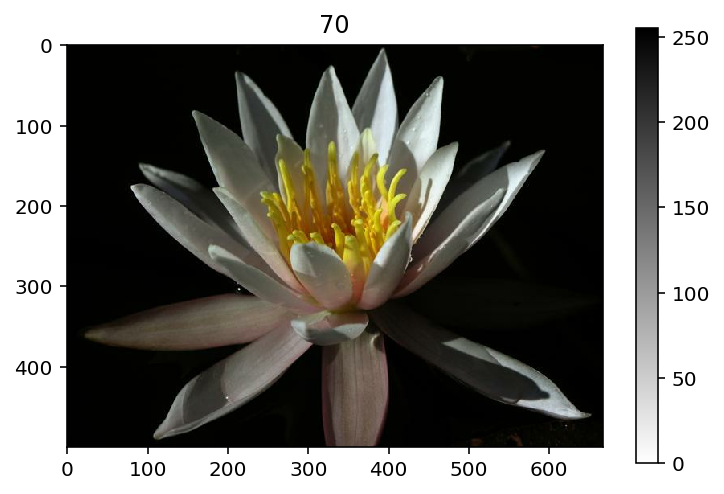

In [10]:
# Plot 1 image from the training set. 
def plot_image(n):
    ''' n is the number of take you would insert
                                                   '''
    for image, label in training_data.take(n):
        image = image.numpy().squeeze()
        label = label.numpy()
    # using imshow to plot the image
    plt.imshow(image, cmap= plt.cm.binary)
    plt.colorbar()

plot_image(1)
# Set the title of the plot to the corresponding image label. 
plt.title(label)
plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [11]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

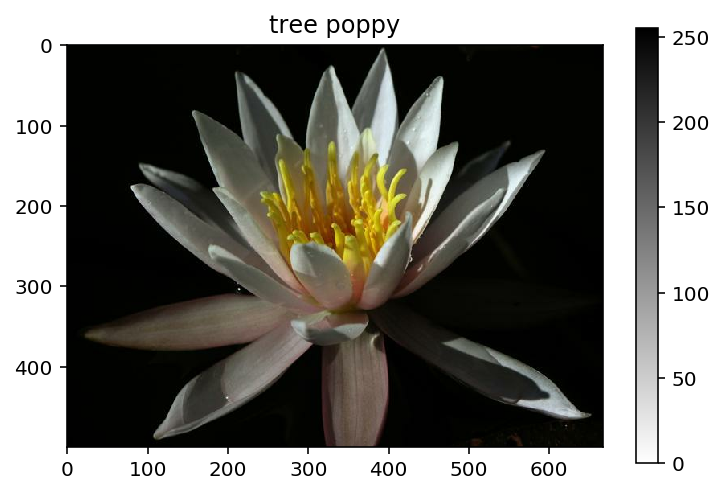

In [12]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
plot_image(1)
name = class_names[str(label)]
plt.title(name)
plt.show()

## Create Pipeline

In [13]:
# Create a pipeline for each set.

#no. of training examples for a mini batch that ranges between 10 and 1000, and defining the image size
batch_size = 128
image_size = 224

# Defining Normalization function for each dataset:
def normalize(image, label):
    #converting pcs from 8 to 32 bytes type
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image,(image_size, image_size))
    #dividing by the max value, so that the values are between 0 and 255
    image /= 255
    return(image, label)



#creating a pipeline with the following characteristics:
#batching shold be applied after normalizing the data
training_batches = training_data.shuffle(training_examples // 4).map(normalize).batch(batch_size).prefetch(1)
validation_batches = validations_data.map(normalize).batch(batch_size).prefetch(1)
test_batches = test_data.map(normalize).batch(batch_size).prefetch(1)

#cache is used in case my GPU can handle the memory size and here it is ok because the dataset is not big
#shuffled 25% of the training examples to svae time
#we map the normailzation function that we earlier defined
#we use prefetch to prepare for the next step of code to save time

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [14]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# The module contains a trained instance of the network, packaged to get feature vectors from images.
# This module does not include the classification layer it was originally made for
# This module can be used with the hub.KerasLayer
# For this module, the size of the input images is fixed to height x width = 224 x 224 pixels.

# The input shape of our images should be the same as the ones for the module used which are 224x224
# Freezing the original weights to not modify them during training as
feature_extractor = hub.KerasLayer(url, input_shape = (image_size, image_size, 3), trainable = False)

In [15]:
# Build your network.
model = tf.keras.Sequential([feature_extractor,
                             tf.keras.layers.Dense(classes, activation = 'softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
# Train your network.
# We would first enable GP
print('Is there a GPU Available:', tf.test.is_gpu_available())
# GPU is not available, so I will run it on local CPU

Is there a GPU Available: False


In [18]:
from workspace_utils import active_session

with active_session():
    model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    # Here we choose to monitor validaion loss, and wait for 3 values that it is not improved
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)
    EPOCHS = 30
    history = model.fit(training_batches,
                        epochs = EPOCHS,
                        validation_data = validation_batches)

Epoch 1/30
8/8 [==============================] - 131s 17s/step - loss: 4.9335 - accuracy: 0.0093 - val_loss: 4.1201 - val_accuracy: 0.0912
Epoch 2/30
8/8 [==============================] - 123s 16s/step - loss: 3.6693 - accuracy: 0.1967 - val_loss: 3.3776 - val_accuracy: 0.3294
Epoch 3/30
8/8 [==============================] - 123s 16s/step - loss: 2.8039 - accuracy: 0.5683 - val_loss: 2.7512 - val_accuracy: 0.5353
Epoch 4/30
8/8 [==============================] - 122s 16s/step - loss: 2.0241 - accuracy: 0.7893 - val_loss: 2.2791 - val_accuracy: 0.6275
Epoch 5/30
8/8 [==============================] - 124s 17s/step - loss: 1.5388 - accuracy: 0.8764 - val_loss: 1.9395 - val_accuracy: 0.6951
Epoch 6/30
8/8 [==============================] - 124s 17s/step - loss: 1.1496 - accuracy: 0.9368 - val_loss: 1.7007 - val_accuracy: 0.7225
Epoch 7/30
8/8 [==============================] - 122s 16s/step - loss: 0.9050 - accuracy: 0.9519 - val_loss: 1.5257 - val_accuracy: 0.7500
Epoch 8/30
8/8 [====

In [19]:
list(history.history.keys())

['loss', 'accuracy', 'val_loss', 'val_accuracy']

Text(0, 0.5, 'Loss')

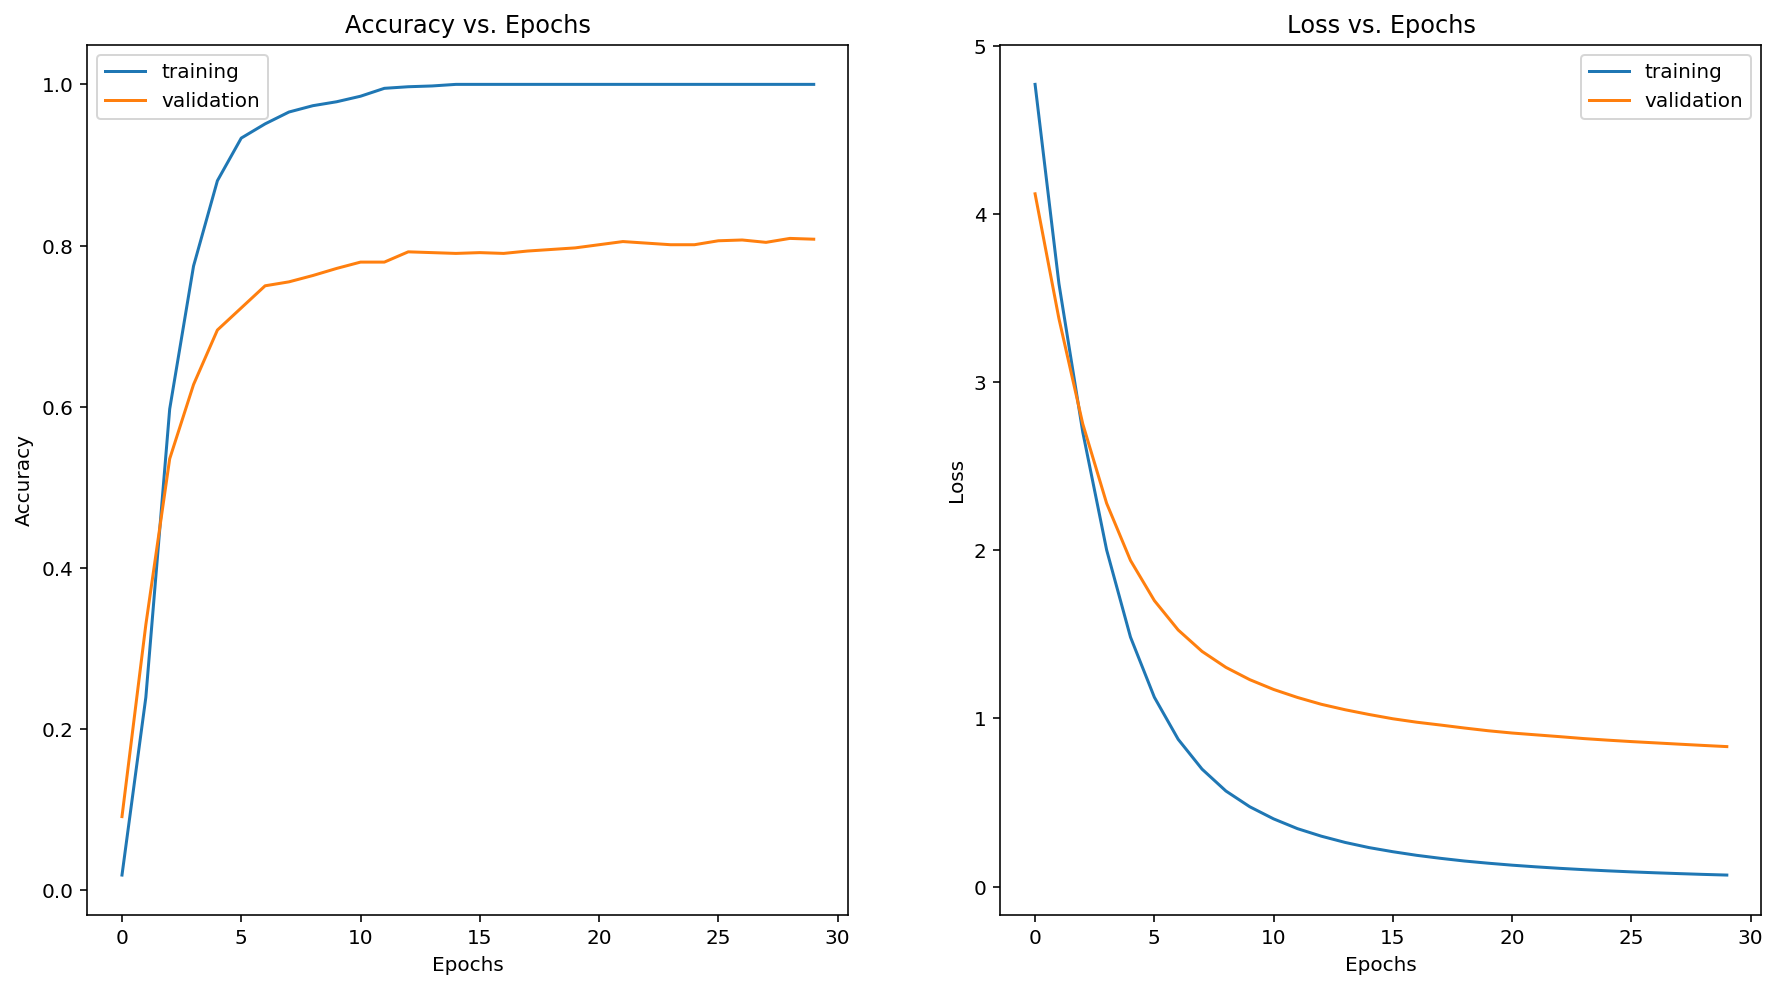

In [20]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), training_accuracy, label ='training')
plt.plot(range(EPOCHS), val_accuracy, label ='validation')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), training_loss, label ='training')
plt.plot(range(EPOCHS), val_loss, label ='validation')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

4/4 [==============================] - 7s 2s/step - loss: 0.9040 - accuracy: 0.8125


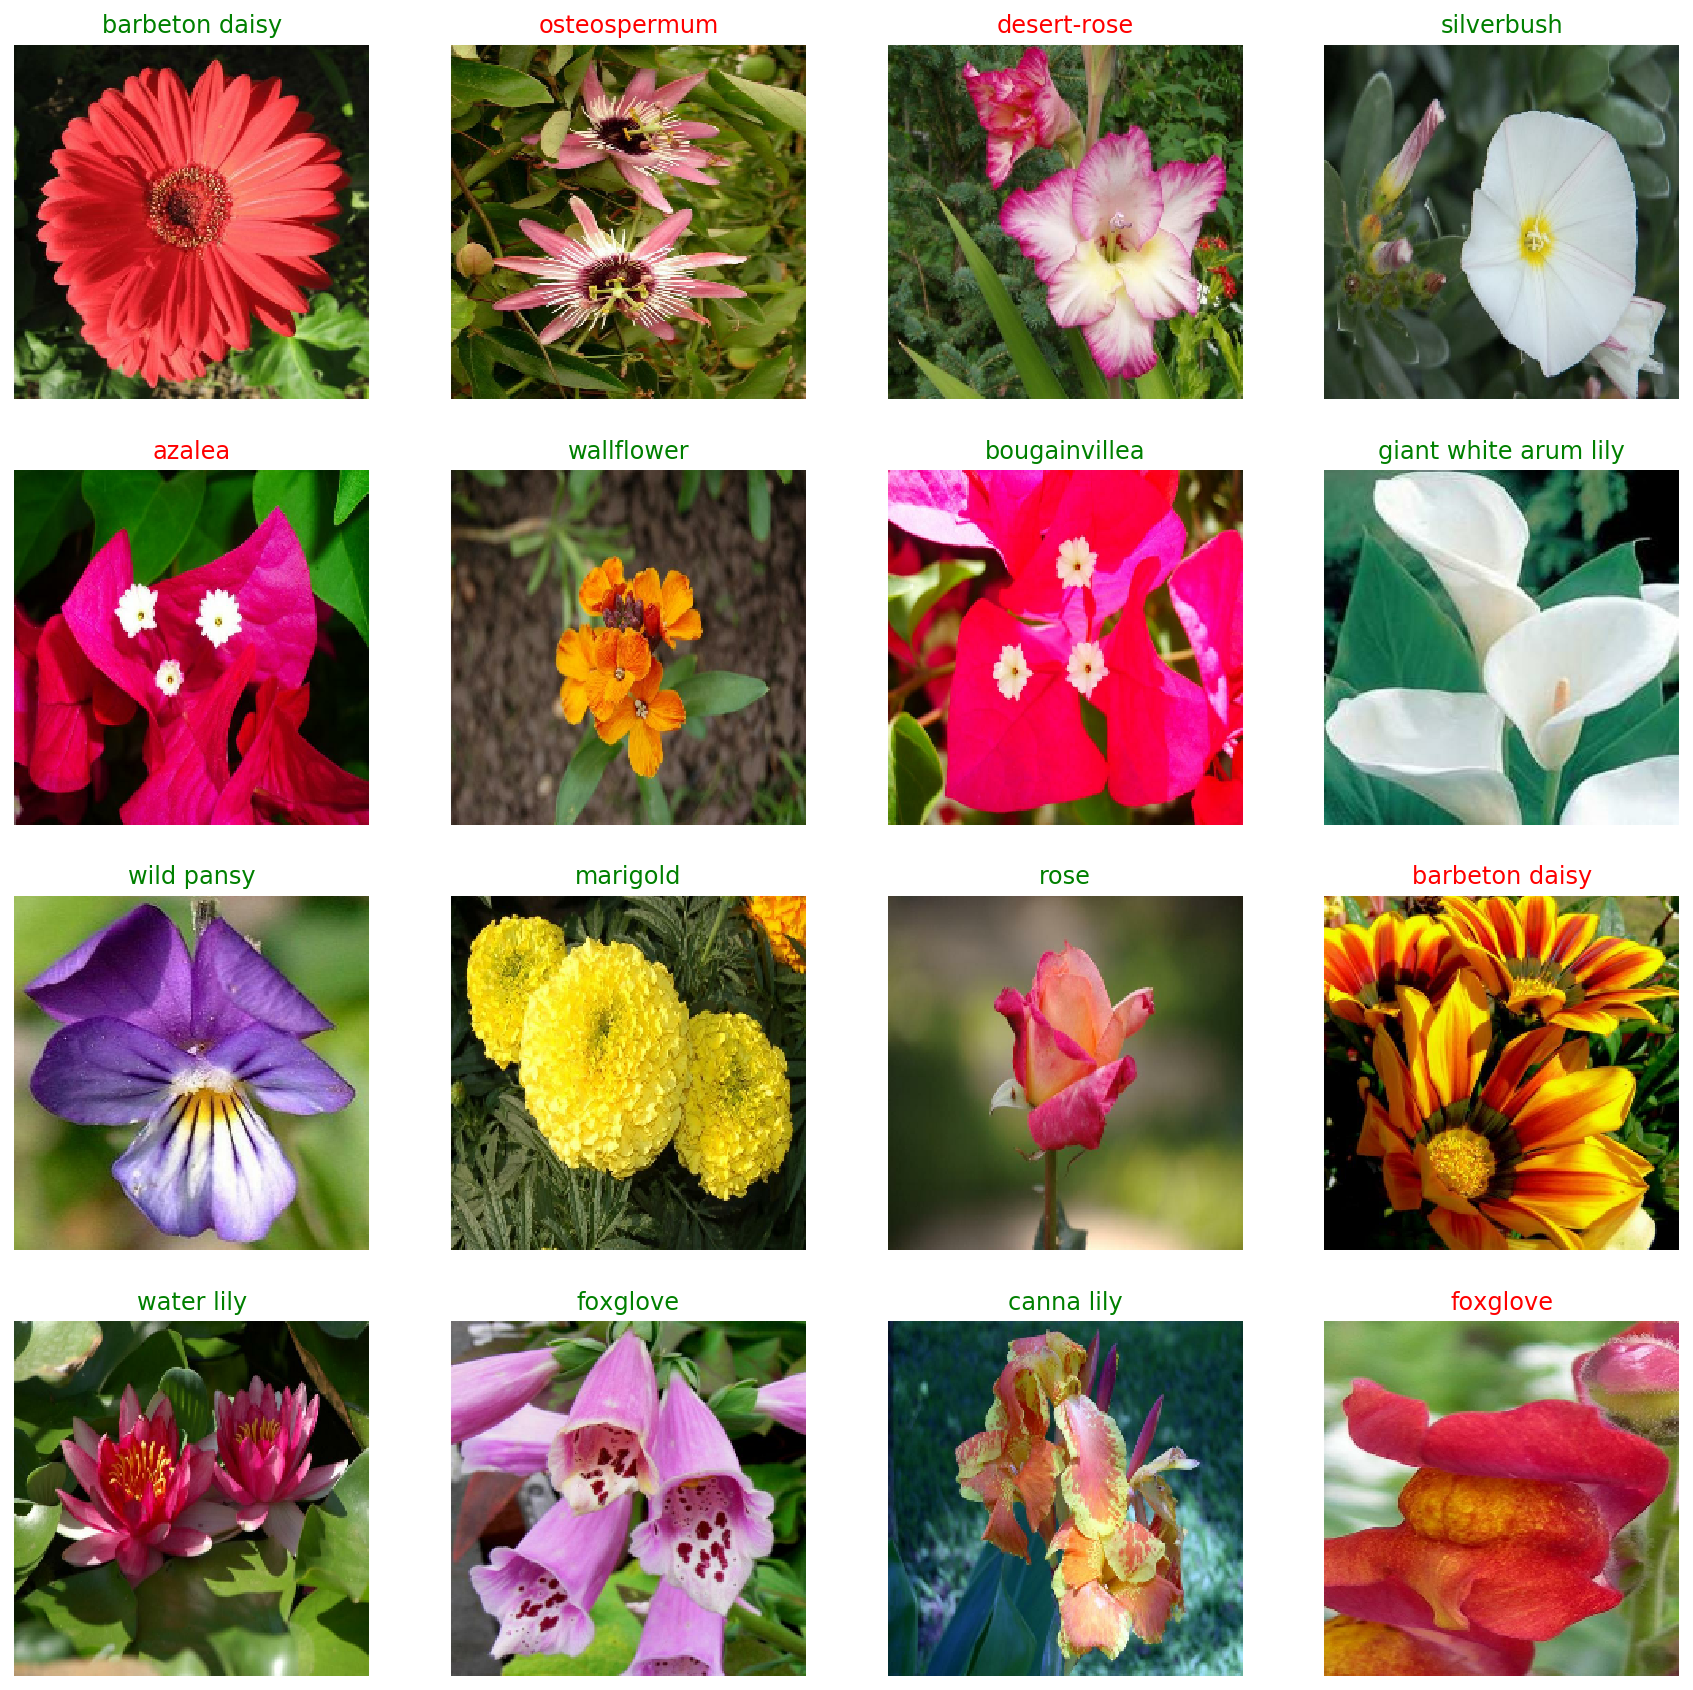

In [30]:
# Inference for the model on pictures
for image_batch, label_batch in test_batches.take(1):
    #predicting the label
    ps = model.predict(image_batch)
    #calculating loss and accuracy for each pic
    loss, accuracy = model.evaluate(image_batch, label_batch)
    image_n = image_batch.numpy().squeeze()
    label_n = label_batch.numpy()

plt.figure(figsize=(15,15))
for n in range(16):
    plt.subplot(4,4,n+1)
    plt.imshow(image_n[n])
    plt.axis('off')
    #showing green color of the title if the highest probable label for the pic is the same as the real output
    color = 'green' if np.argmax(ps[n]) == label_n[n] else 'red'
    #plotting the name corresponding to the label number
    #since the indices of np.array starts from zero, we would add 1, so that it would be matching with flowers 
    #labels starting from 1 to 102 while ps indices are from 0 to 101.
    plt.title(class_names[str(np.argmax(ps[n])+1)], color = color)

In [22]:
# Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(test_batches)
print('Loss in test data is: {:.3}'.format(loss))
print('accuracy in test data is: {:.2%}'.format(accuracy))

49/49 [==============================] - 387s 8s/step - loss: 0.9759 - accuracy: 0.7738
Loss in test data is: 0.976
accuracy in test data is: 77.38%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [23]:
# Save your trained model as a Keras model.
t = time.time()
saved_keras_filepath = "./oxfordflowers_{}.h5".format(int(t))
model.save(saved_keras_filepath)
print("The model is saved successfully.......")

The model is saved successfully.......


## Load the Keras Model

Load the Keras model you saved above.

In [24]:
# Load the Keras model
# we need to use customm_objects 
# it is optional dictionary mapping names (strings) to custom classes or functions to be considered during deserialization.
loaded = tf.keras.models.load_model(saved_keras_filepath, custom_objects={'KerasLayer':hub.KerasLayer})
print("The model is loaded successfully")
loaded.summary()

The model is loaded successfully
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
# Loading the original model to compare that both models are identical
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [26]:
# Create the process_image function
# processing the pic so that it would be of the suitable size to be used with my model
def process_image(image):
    image = tf.cast(image, tf.float32)
    # Image size is previously defined as 224
    image = tf.image.resize(image,(image_size, image_size))
    #normalizing so that it is between 0 and 1
    image = image / 255
    image = image.numpy()
    return(image)

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

The shape of the processed image is:  (224, 224, 3)


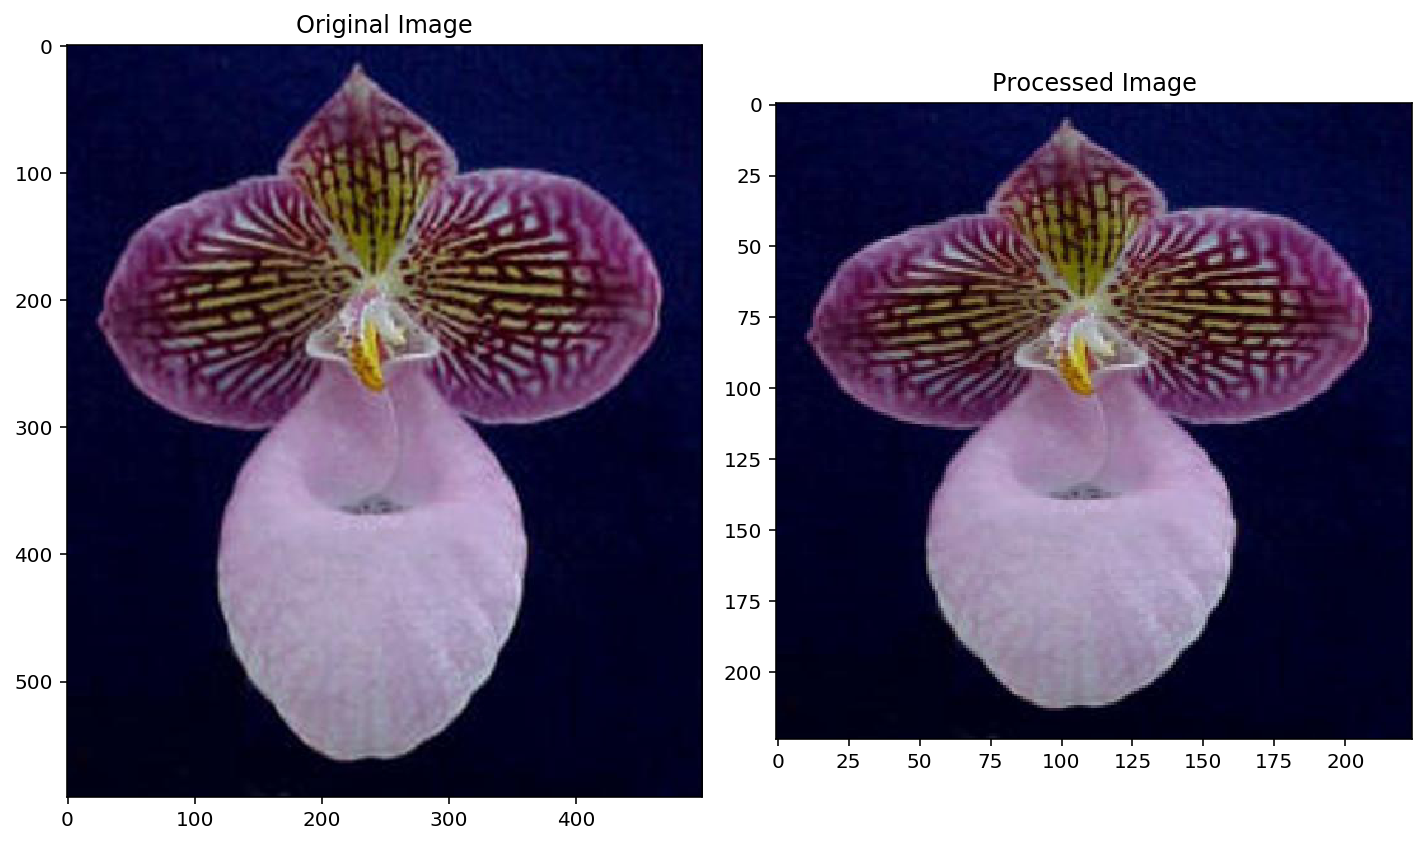

In [27]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)
print("The shape of the processed image is: ",processed_test_image.shape)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [46]:
# Create the predict function
def predict(image_path, model_used, top_k):
    # PIL.Image.open(fp, mode='r', formats=None)
    image = Image.open(image_path)
    image = np.asarray(image)
    #to make the shape as (224,224,3)
    image = process_image(image)
    # numpy.expand_dims(a, axis) and add one extra dimension
    image = np.expand_dims(image, axis=0)
   
    #using the saved model to make the prediction
    ps = model_used.predict(image)
    label_list = np.arange(classes)
    probabilities = ps[0]
    # sorting the probability descendingly and showing the indices of them
    probabilities_indices = probabilities.argsort()[-top_k:][::-1]
    top_k_probabilities = probabilities[probabilities_indices]
    print('Top {} probabilities are: {}'.format(top_k, top_k_probabilities))
    # Here we again added 1 to the indices to match the oxford flowers numbers
    top_k_labels = label_list[probabilities_indices+1]
    labels_names = [class_names[str(label)] for label in top_k_labels]
    print('They correspond to lables of: {}'.format(top_k_labels))
    print('The labels are: {}'.format(labels_names))
    print("."*40)
    return (top_k_probabilities, top_k_labels)

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

Top 5 probabilities are: [0.8418245  0.03724144 0.02993454 0.01253178 0.0111202 ]
They correspond to lables of: [61 46 24 11 39]
The labels are: ['cautleya spicata', 'wallflower', 'red ginger', 'snapdragon', 'siam tulip']
........................................
Top 5 probabilities are: [9.9114603e-01 1.1270490e-03 9.5502287e-04 9.2825340e-04 7.7170174e-04]
They correspond to lables of: [ 2 68  7 80  6]
The labels are: ['hard-leaved pocket orchid', 'bearded iris', 'moon orchid', 'anthurium', 'tiger lily']
........................................
Top 5 probabilities are: [0.35148627 0.29651117 0.0415584  0.03892258 0.03258587]
They correspond to lables of: [59  5 66 41 71]
The labels are: ['orange dahlia', 'english marigold', 'osteospermum', 'barbeton daisy', 'gazania']
........................................
Top 5 probabilities are: [0.9773616  0.00363377 0.00256003 0.00208043 0.0017516 ]
They correspond to lables of: [52 19 64 69 34]
The labels are: ['wild pansy', 'balloon flower', '

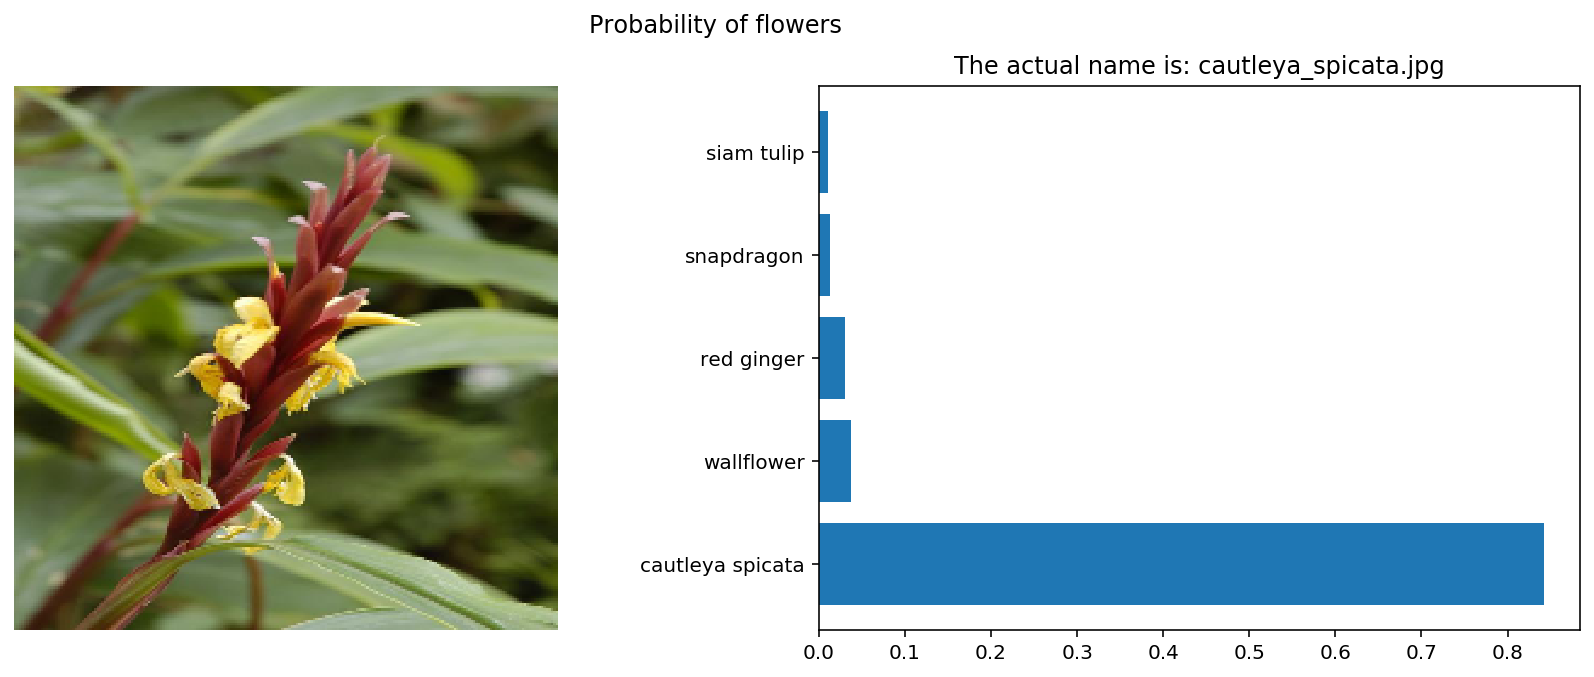

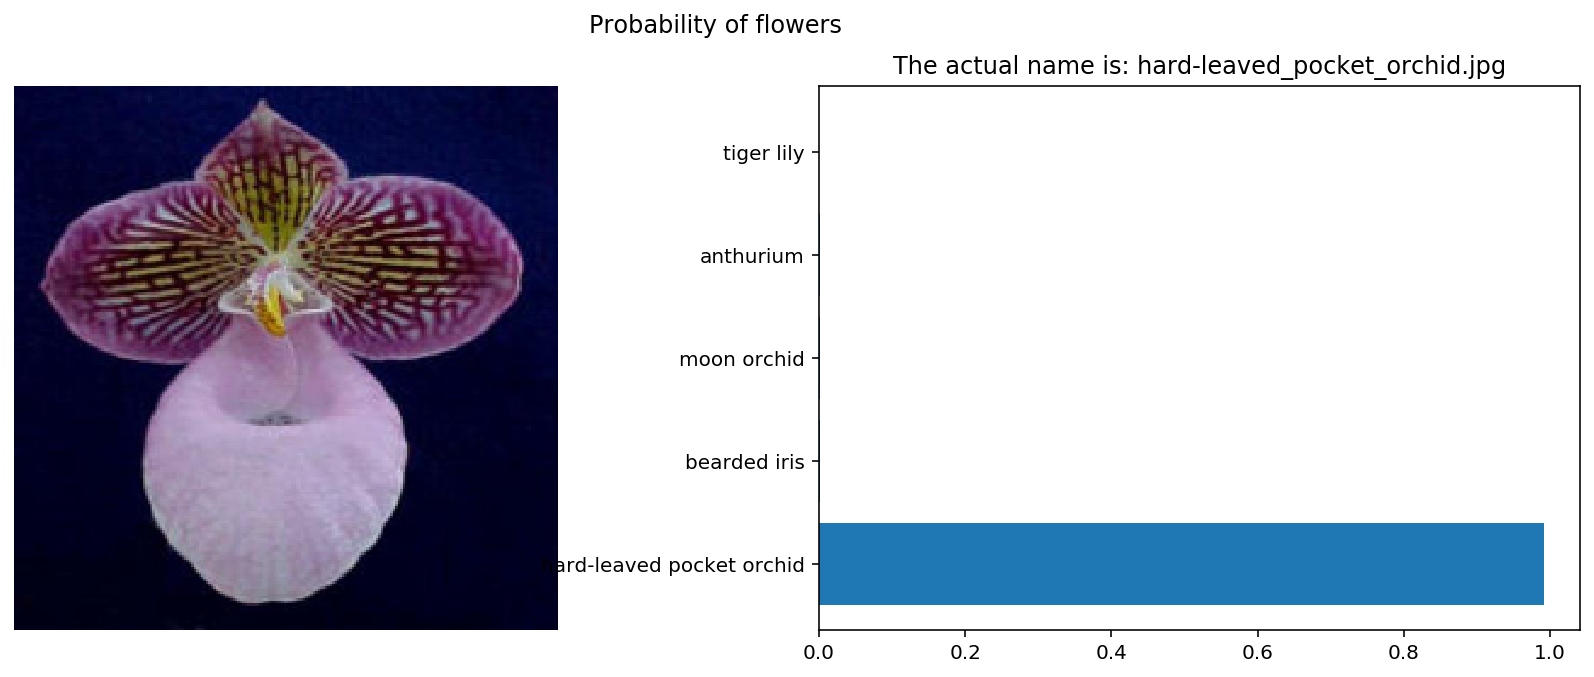

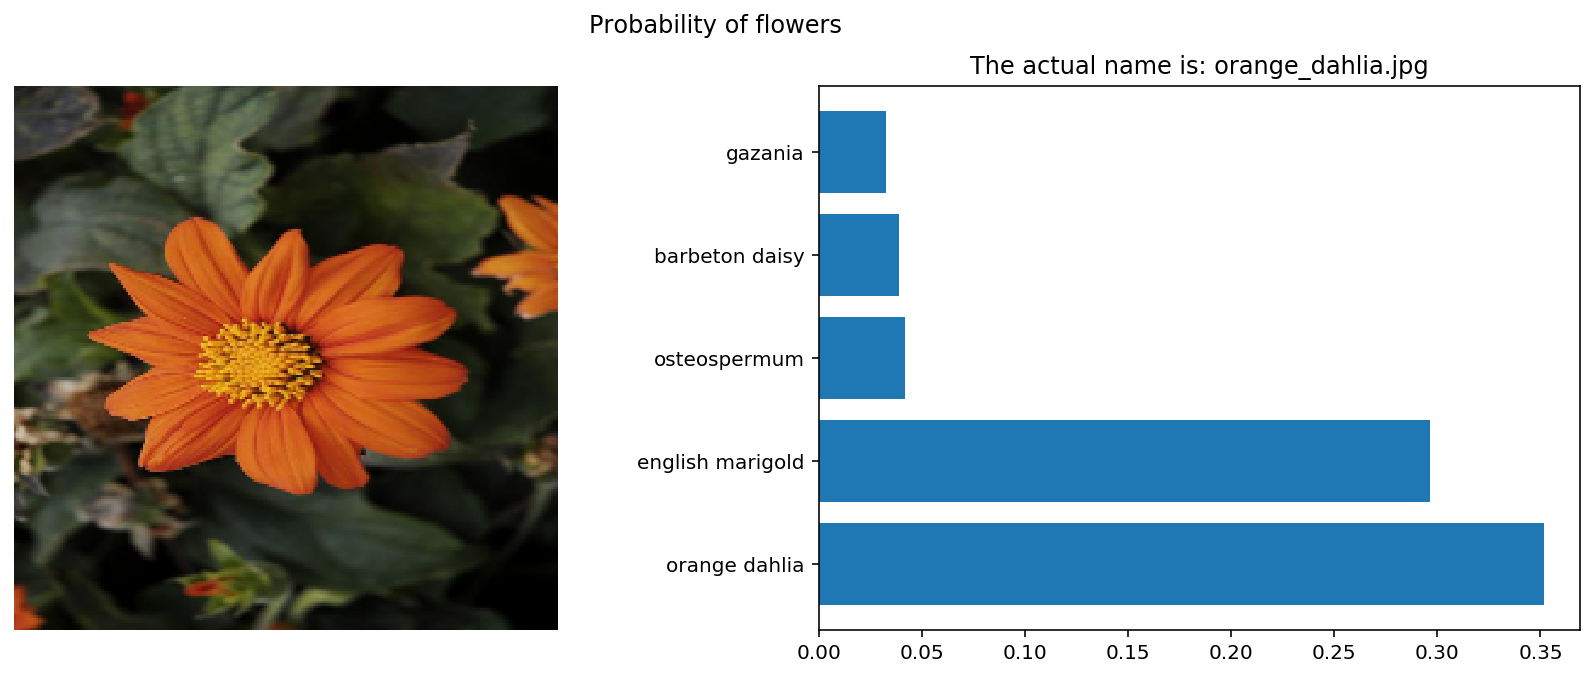

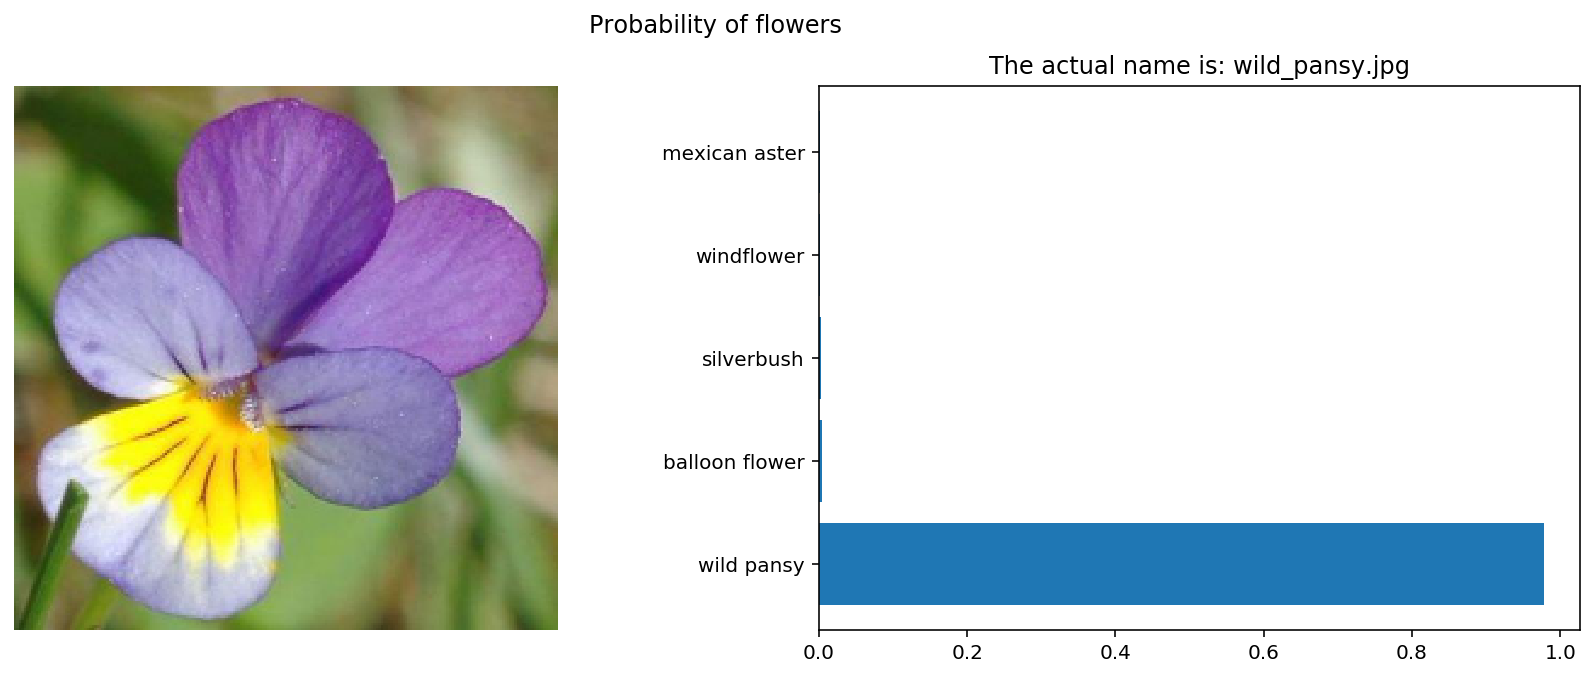

In [57]:
# TODO: Plot the input image along with the top 5 classes
images = ["cautleya_spicata.jpg", "hard-leaved_pocket_orchid.jpg", "orange_dahlia.jpg", "wild_pansy.jpg"]
top_k = 5
for n, im in enumerate(images):
    image_path = "./test_images/{}".format(images[n])
    image = Image.open(image_path)
    image = np.asarray(image)
    image = process_image(image)
    probs, classes_labels = predict(image_path, loaded, top_k)
    labels_names = [class_names[str(label)] for label in classes_labels]
    fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2)
    ax1.imshow(image)
    ax1.axis('off')
    plt.title('The actual name is: {}'.format(im))
    ax2.barh(labels_names, probs)
    plt.suptitle('Probability of flowers')